In [1]:
import config
import torch
import torch.optim as optim

import numpy as np

import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt

from model import YOLOv3
from tqdm import tqdm
from utils import (
    mean_average_precision,
    cells_to_bboxes,
    get_evaluation_bboxes,
    save_checkpoint,
    load_checkpoint,
    check_class_accuracy,
    get_loaders,
    plot_couple_examples
)
from loss import YoloLoss
import warnings

from dataset import YOLODataset

warnings.filterwarnings("ignore")

torch.backends.cudnn.benchmark = True

In [2]:
model = YOLOv3(num_classes=config.NUM_CLASSES).to('cpu')
optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)
loss_fn = YoloLoss()
scaler = torch.cuda.amp.GradScaler()

train_loader, test_loader, train_eval_loader = get_loaders(train_csv_path=config.DATASET + "/train.csv"
                                                           , test_csv_path=config.DATASET + "/test.csv")

In [4]:
train_dataset = YOLODataset(
    config.DATASET + "/train.csv",
    #transform = config.train_transforms,
    transform = False,
    
    S=[config.IMAGE_SIZE // 32, config.IMAGE_SIZE // 16, config.IMAGE_SIZE // 8],
    img_dir=config.IMG_DIR,
    label_dir=config.LABEL_DIR,
    anchors=config.ANCHORS)

In [35]:
original = train_dataset[0][0].astype('float32')

In [47]:
mean = original[:, :, 0].mean()
std = original[:, :, 0].std()

In [50]:
mean = 0.48
std = 0.28

mean *= 255
std *= 255

In [37]:
output = (original[:, :, 0] - mean)/std

In [38]:
output.mean()

-1.0118798e-07

In [39]:
output.std()

1.0000001

(array([[ 86.,  91.,  50., ...,  16.,   3.,   2.],
        [ 94.,  81.,  31., ...,  16.,   3.,   0.],
        [103.,  63.,  27., ...,  16.,   1.,   1.],
        ...,
        [  4.,  20.,  43., ...,  23.,  88.,   3.],
        [  5.,  22.,  37., ...,  31.,  83.,   3.],
        [  7.,  20.,  34., ...,  37.,  86.,   0.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 640 BarContainer objects>)

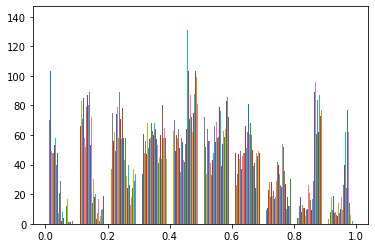

In [34]:
plt.hist(original[:, :, 0]/255)

In [65]:
train_transforms = A.Blur(blur_limit=7, p=1)

train_dataset = YOLODataset(
    config.DATASET + "/train.csv",
    transform = train_transforms,
    #transform = False,
    S=[config.IMAGE_SIZE // 32, config.IMAGE_SIZE // 16, config.IMAGE_SIZE // 8],
    img_dir=config.IMG_DIR,
    label_dir=config.LABEL_DIR,
    anchors=config.ANCHORS)

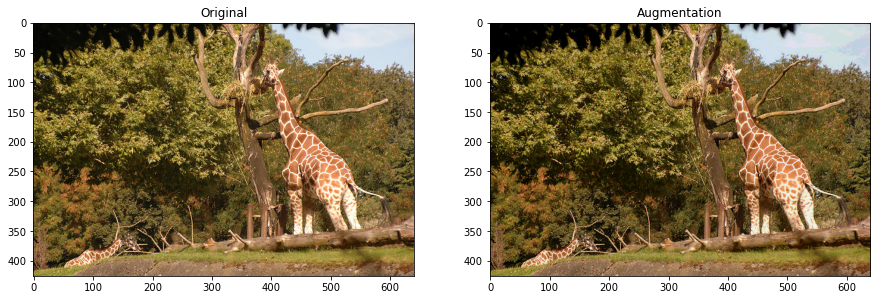

In [328]:
augmentation_image = A.Posterize(num_bits=4, p=1)(image=original)['image']

        
plt.figure(figsize=(15, 15))

plt.subplot(1, 2, 1)
plt.title('Original')
plt.imshow(original, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Augmentation')
plt.imshow(augmentation_image)

In [329]:
def posterize(img, bits):
    """Reduce the number of bits for each color channel.
    Args:
        img (numpy.ndarray): image to posterize.
        bits (int): number of high bits. Must be in range [0, 8]
    Returns:
        numpy.ndarray: Image with reduced color channels.
    """
    bits = np.uint8(bits)

    if img.dtype != np.uint8:
        raise TypeError("Image must have uint8 channel type")
    if np.any((bits < 0) | (bits > 8)):
        raise ValueError("bits must be in range [0, 8]")

    if not bits.shape or len(bits) == 1:
        if bits == 0:
            return np.zeros_like(img)
        if bits == 8:
            return img.copy()

        lut = np.arange(0, 256, dtype=np.uint8)
        mask = ~np.uint8(2 ** (8 - bits) - 1)
        lut &= mask

        return cv2.LUT(img, lut)

    if not is_rgb_image(img):
        raise TypeError("If bits is iterable image must be RGB")

    result_img = np.empty_like(img)
    for i, channel_bits in enumerate(bits):
        if channel_bits == 0:
            result_img[..., i] = np.zeros_like(img[..., i])
        elif channel_bits == 8:
            result_img[..., i] = img[..., i].copy()
        else:
            lut = np.arange(0, 256, dtype=np.uint8)
            mask = ~np.uint8(2 ** (8 - channel_bits) - 1)
            lut &= mask

            result_img[..., i] = cv2.LUT(img[..., i], lut)

    return result_img

In [ ]:
def posterize(img, bits):
    """Reduce the number of bits for each color channel.
    Args:
        img (numpy.ndarray): image to posterize.
        bits (int): number of high bits. Must be in range [0, 8]
    Returns:
        numpy.ndarray: Image with reduced color channels.
    """
    bits = np.uint8(bits)

    if img.dtype != np.uint8:
        raise TypeError("Image must have uint8 channel type")
    if np.any((bits < 0) | (bits > 8)):
        raise ValueError("bits must be in range [0, 8]")

    if not bits.shape or len(bits) == 1:
        if bits == 0:
            return np.zeros_like(img)
        if bits == 8:
            return img.copy()

        lut = np.arange(0, 256, dtype=np.uint8)
        mask = ~np.uint8(2 ** (8 - bits) - 1)
        lut &= mask

        return cv2.LUT(img, lut)

    if not is_rgb_image(img):
        raise TypeError("If bits is iterable image must be RGB")

    result_img = np.empty_like(img)
    for i, channel_bits in enumerate(bits):
        if channel_bits == 0:
            result_img[..., i] = np.zeros_like(img[..., i])
        elif channel_bits == 8:
            result_img[..., i] = img[..., i].copy()
        else:
            lut = np.arange(0, 256, dtype=np.uint8)
            mask = ~np.uint8(2 ** (8 - channel_bits) - 1)
            lut &= mask

            result_img[..., i] = cv2.LUT(img[..., i], lut)

    return result_img